# Explore the SCD data set

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import re

In [3]:
from matminer.utils.conversions import str_to_composition
from matminer.featurizers.composition import ElementProperty
from matminer.featurizers.composition import ElementFraction

In [4]:
def refresh_scd():
    return pd.read_pickle('../deliver/NIST_CeramicDataSet.pkl')

def refresh_scd_sort():
    scd= refresh_scd()
    return scd.sort_values(['chemicalFormula'])

def refresh_scd_modified():
    '''
    Imports from the modified data frame where preparation entries have been converted to string
    Sorts them by the chemical formula
    '''
    scd= pd.read_pickle('../deliver/NIST_CeramicDataSet_prepModified.pkl')
    return scd.sort_values(['chemicalFormula'])

In [5]:
scd= refresh_scd()

## Some basic exploration

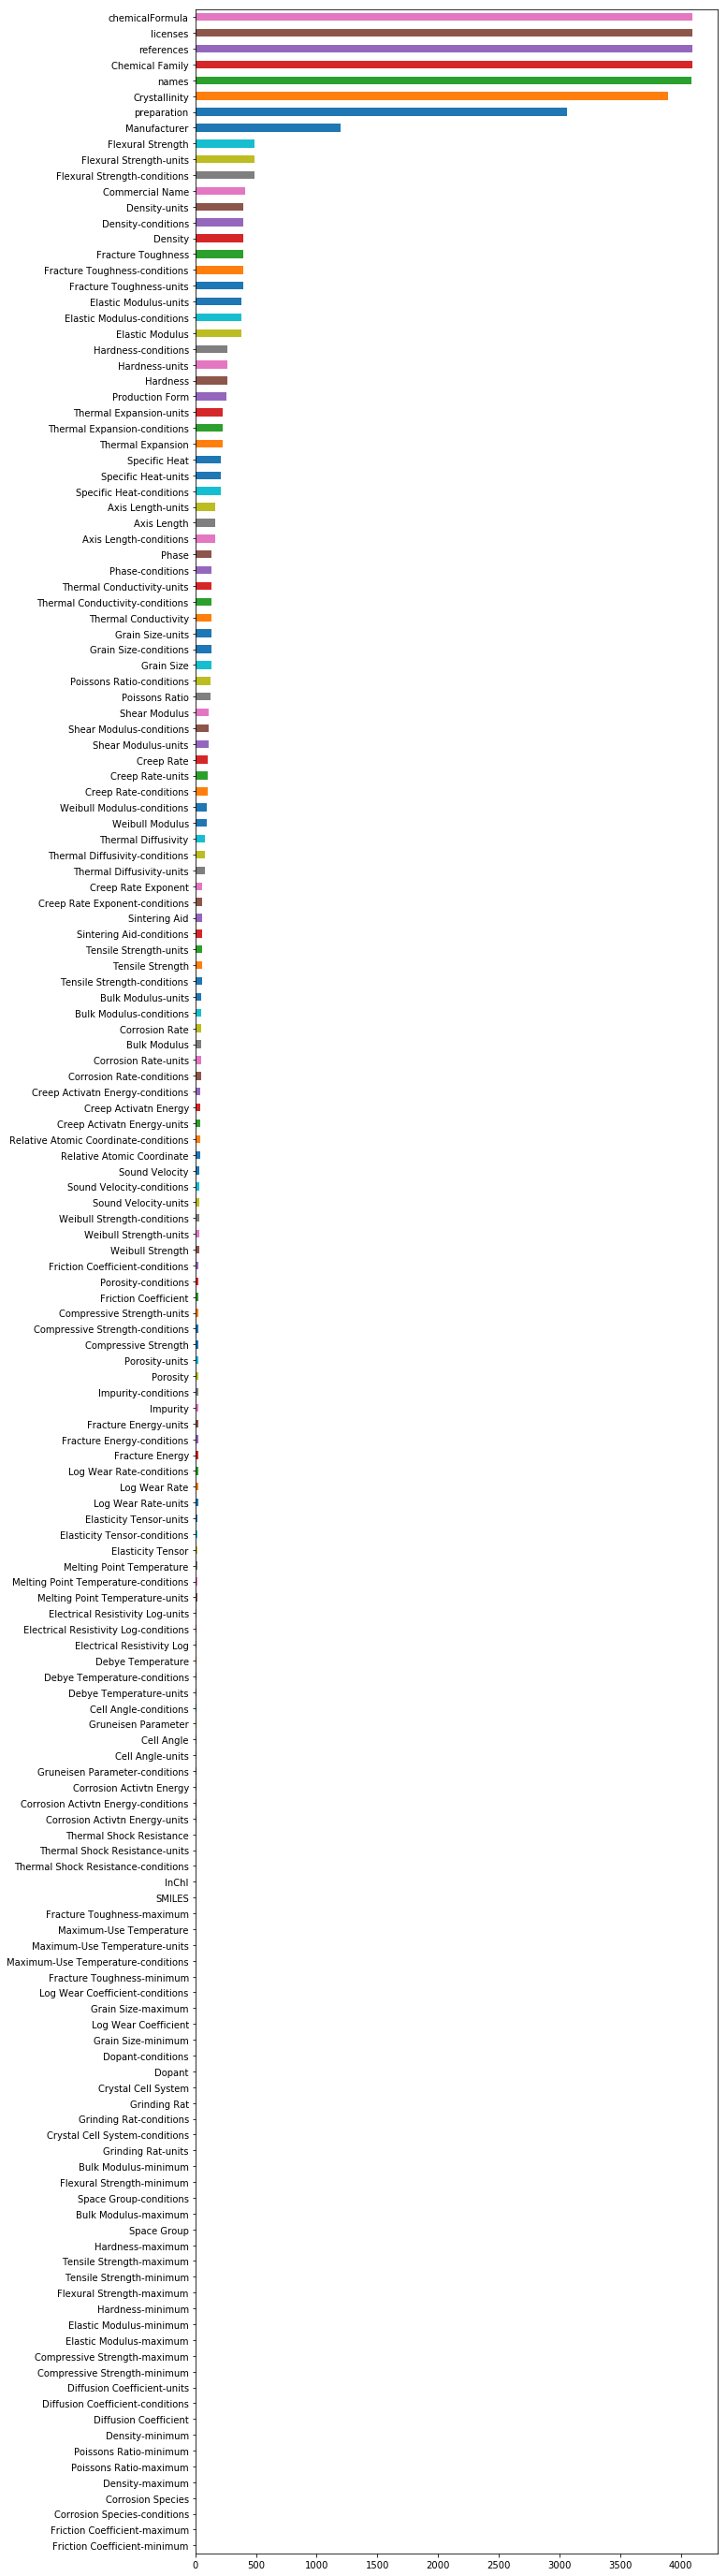

In [6]:
plt.figure(figsize= (10,50))
scd.count().sort_values().plot.barh()
plt.show()
plt.close()

The number of entries for name, chemicalFormula and Chemical Family are the same but the number of unique entries is different

In [7]:
print('Number of unique chemical Formulae: %i'%len(np.unique(scd['chemicalFormula'].dropna())))
print('Number of unique names: %i'%len(np.unique(scd['names'].dropna())))
print('Number of unique chemical families: %i' %len(np.unique(scd['Chemical Family'].dropna())))
print('Number of unique licenses: %i'%len(np.unique(scd['licenses'].dropna())))
# print('Number of unique references: %i'%len(np.unique(scd['references'].values))) 
# references is in the form of a dictionary---hard to parse.

Number of unique chemical Formulae: 309
Number of unique names: 151
Number of unique chemical families: 201
Number of unique licenses: 1


Check that all entries are in the same units

In [8]:
flag= False
for item in scd.keys():
    if not('units' in item):
        continue
    if len(np.unique(scd[item].dropna()))==1:
        continue
    print(item)
    flag= True
if not(flag):
    print('All entries quoted in the same units')

All entries quoted in the same units


Lets choose some subset of the parameters to look at

Lets take a look at some data columns that have a decent number of entries. Unfortunately, it seems that a lot of the items that have entries for densities do not have entries for these columns like elastic modulus, hardness etc. Can we use matminer to fill in the denisities for those materials?

Lets try to look at some of these data columns. Find clustered values or something

In [9]:
scd_count= scd.count().sort_values()
mask= (scd_count>100) & (scd_count<800)
datKeys= scd_count[mask].keys()

In [10]:
print(datKeys)

Index(['Creep Rate-conditions', 'Creep Rate-units', 'Creep Rate',
       'Shear Modulus-units', 'Shear Modulus-conditions', 'Shear Modulus',
       'Poissons Ratio', 'Poissons Ratio-conditions', 'Grain Size',
       'Grain Size-conditions', 'Grain Size-units', 'Thermal Conductivity',
       'Thermal Conductivity-conditions', 'Thermal Conductivity-units',
       'Phase-conditions', 'Phase', 'Axis Length-conditions', 'Axis Length',
       'Axis Length-units', 'Specific Heat-conditions', 'Specific Heat-units',
       'Specific Heat', 'Thermal Expansion', 'Thermal Expansion-conditions',
       'Thermal Expansion-units', 'Production Form', 'Hardness',
       'Hardness-units', 'Hardness-conditions', 'Elastic Modulus',
       'Elastic Modulus-conditions', 'Elastic Modulus-units',
       'Fracture Toughness-units', 'Fracture Toughness-conditions',
       'Fracture Toughness', 'Density', 'Density-conditions', 'Density-units',
       'Commercial Name', 'Flexural Strength-conditions',
       'Fle

In [11]:
# get rid of useless data columns
datKeys= [key for key in datKeys if not('units' in key or 'conditions' in key)]

Creep Rate key: Number of colums 8


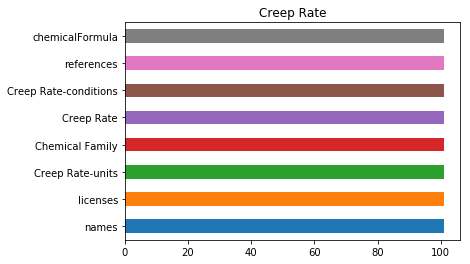

Shear Modulus key: Number of colums 9


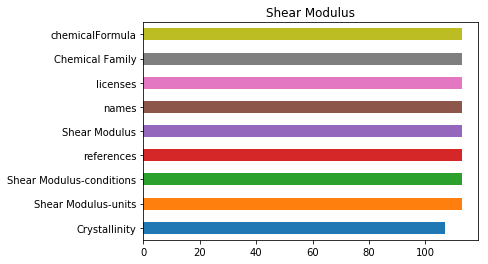

Poissons Ratio key: Number of colums 8


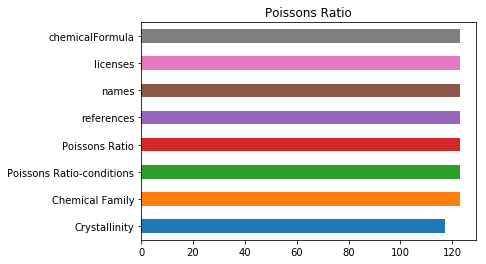

Grain Size key: Number of colums 10


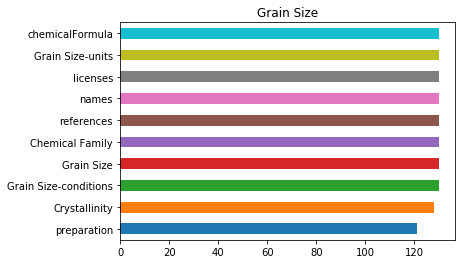

Thermal Conductivity key: Number of colums 9


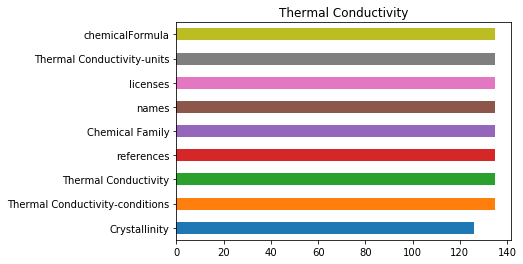

Phase key: Number of colums 9


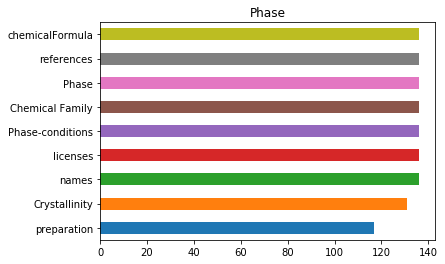

Axis Length key: Number of colums 10


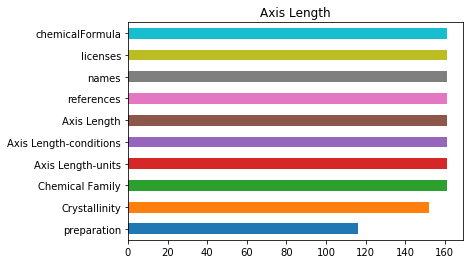

Specific Heat key: Number of colums 10


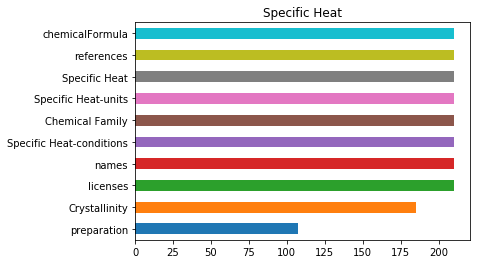

Thermal Expansion key: Number of colums 10


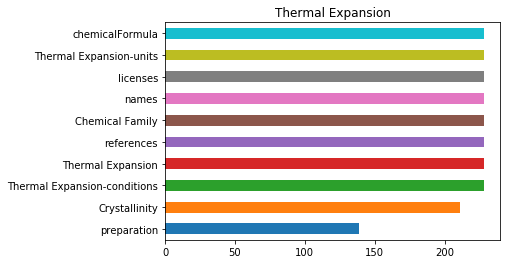

Production Form key: Number of colums 8


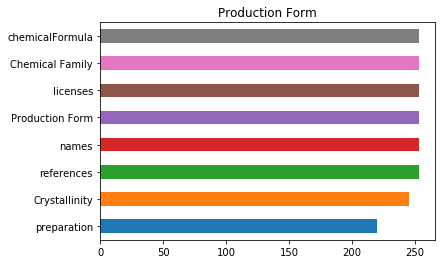

Hardness key: Number of colums 10


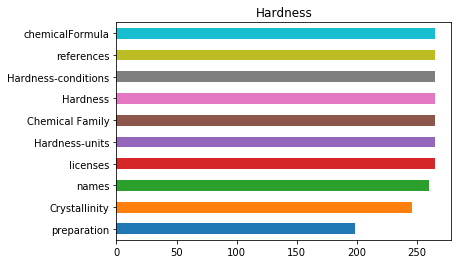

Elastic Modulus key: Number of colums 11


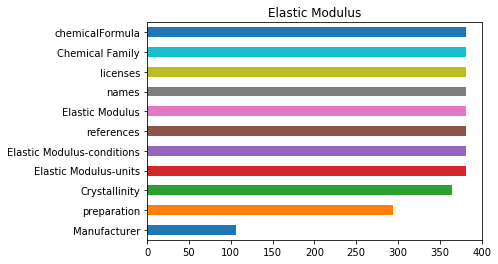

Fracture Toughness key: Number of colums 11


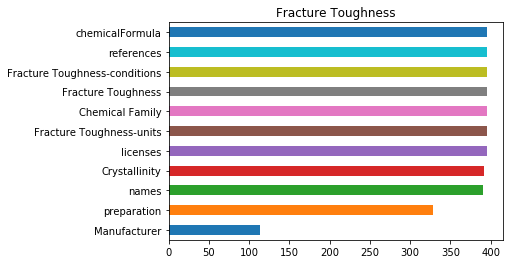

Density key: Number of colums 11


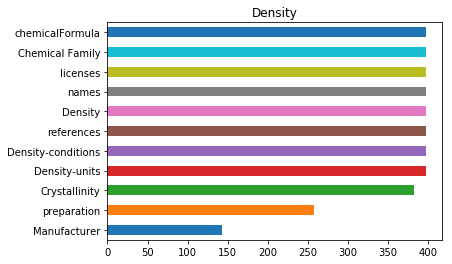

Commercial Name key: Number of colums 9


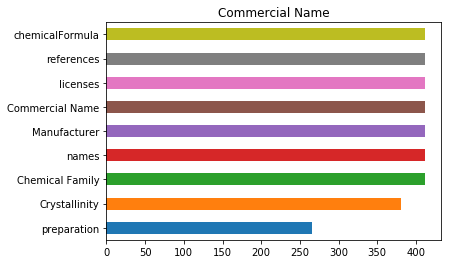

Flexural Strength key: Number of colums 11


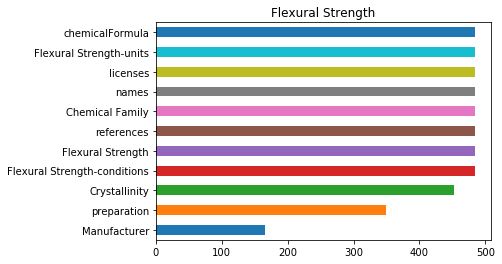

In [12]:
for key in datKeys:
    df= scd[scd.isnull()[key]==False]
    df_count= df.count().sort_values()
    mask= df_count>100
    df_count[mask].plot.barh()
    print('%s key: Number of colums %i'%(key,len(df_count[mask])))
    plt.title(key)
    plt.show()
    plt.close()

Seems like there is NO overlap between these data columns. This data set definitely needs some cleaning!

### I. Club data frame by chemical formula

In [13]:
scd= scd.sort_values(['chemicalFormula'])
chemFormulae_valueCounts= scd['chemicalFormula'].value_counts()

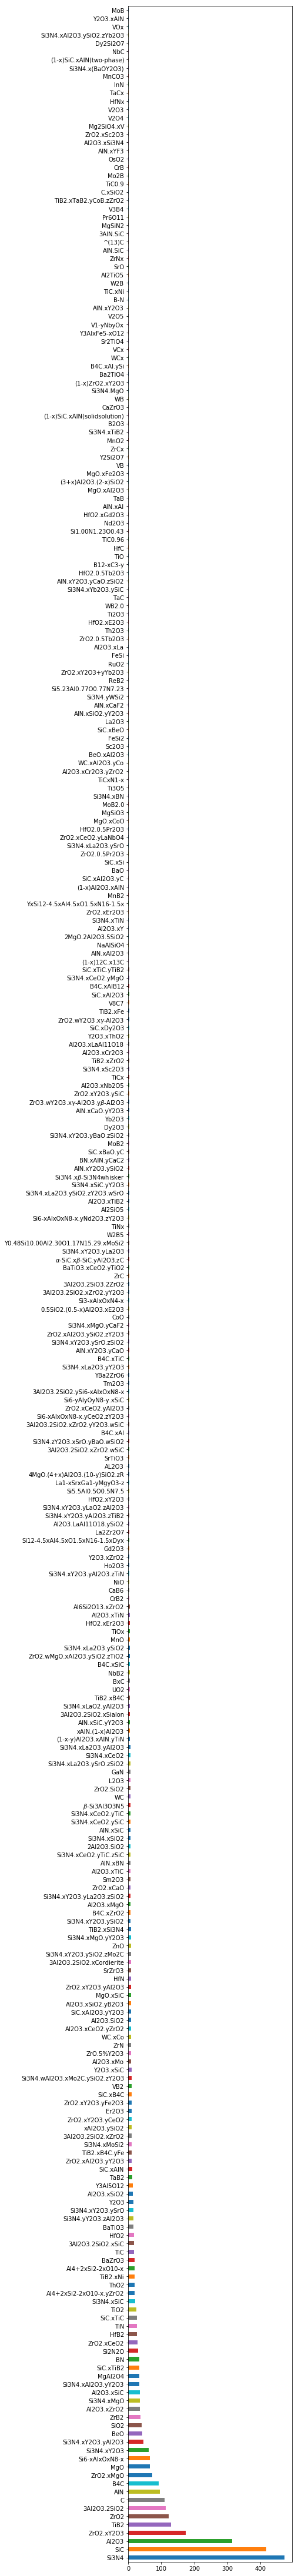

In [14]:
plt.figure(figsize=(5,80))
chemFormulae_valueCounts.plot.barh()
plt.show()
plt.close()

### I.i Change prepration from dictionary

Preparation is in the form of a dictionary! Lets change that to a string!

In [15]:
scd= refresh_scd()
for i,item in enumerate(scd['preparation'].values):
    try:
        key,value= item[0].popitem()
        scd.loc[i+1,'preparation']= value # index counting in data frame seems to start from 1
    except TypeError:
        continue

In [16]:
scd.to_pickle('../deliver/NIST_CeramicDataSet_prepModified.pkl')
scd.to_csv('../deliver/NIST_CeramicDataSet_prepModified.csv')

In [17]:
scd= scd.sort_values('chemicalFormula')

### I.ii Club data for $Si_3N_4$

Lets take a look at $Si_3N_4$

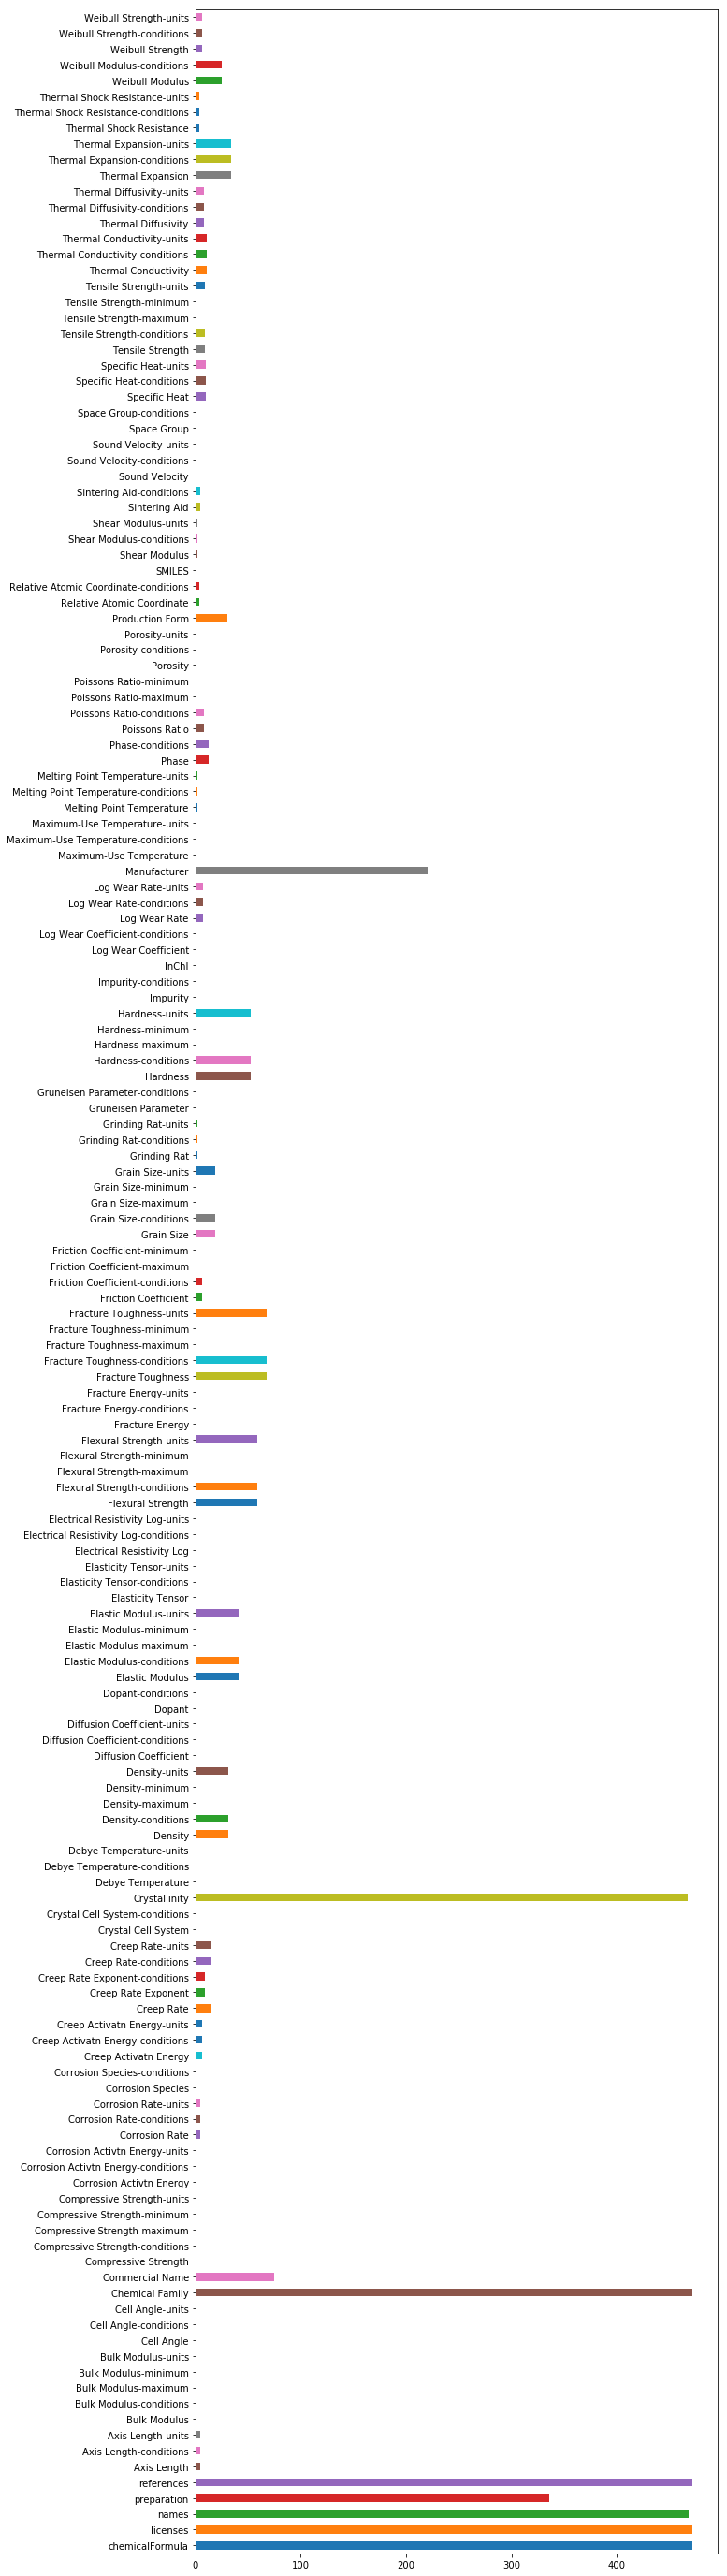

In [18]:
mask= scd['chemicalFormula']=='Si3N4'
df_si3n4= scd[mask]
plt.figure(figsize= (10,50))
df_si3n4.count().plot.barh()
plt.show()
plt.close()

In [24]:
df_si3n4= df_si3n4.sort_values('preparation')
print('Number of unique preparation techniques: %i'%(df_si3n4['preparation'].nunique()))

Number of unique preparation techniques: 9


Plan: 
1. Find redundancy in chemical names/formulae
2. Collapse redundancies
3. Make a smaller data set with just the columns of interest: Elastic Modulus

## Using Chih-Hao's formula parser

In [9]:
scd.loc[3892,'chemicalFormula'] = 'BN' #fix 'B-N' to 'BN'

In [10]:
# Parse the chemicalFormula
def formula_decompose(formula):
    '''
    decompose chemical formula 
    return
        composition: list, [(element,num),...]
            element: string
            num: string, can be math expression such as '1+0.5x'
    '''

    comp = []
    p = re.compile(r'(\d?[w-z]?)([A-Z][a-u]?)(\d*\+?\-?\d*\.?\d*[w-z]?)')

    #split the chemical formula if there is dots, but not for cases like Mg1.5x
    if re.search(r'\.', formula) and not re.search(r'\d+\.\d[w-z]', formula): 
        formula = formula.split('.')
        for item in formula:
            prefactor = '1'
            for i in re.findall(p, item):
                pre, elem, num = i
                if pre:
                    prefactor = pre
                if num == '':
                    num = '1'
                num = prefactor + '*({})'.format(num)
                comp.append((elem, num))
    else:
        prefactor = '1'
        for i in re.findall(p, formula):
            pre, elem, num = i
            if pre:
                prefactor = pre
            if num == '':
                num = '1'
            num = prefactor + '*({})'.format(num)
            comp.append((elem, num))
    return comp 

def formula_reconstruct(composition, x=0.1, y=0.1, z=0.1, w=0.1):
    '''
    reconstruct chemical formula from composition
    composition in form of [(element,num), (element,num),...]
        element: string
        num: string, can be math expression such as '1+0.5x'

    return 
        flat chemcial formula: string, such as 'Ti1.5Cu0.1Au1.0'
    '''
    flat_list = []
    for (elem, num) in composition:
        num = re.sub(r'(\d)([w-z])', r'\1*\2', num) #convert 5x to 5*x
        flat_list.append(elem)
        flat_list.append(format(eval(num), '.1f'))
    return ''.join(flat_list)
  
def formula_parser(formula):
    return formula_reconstruct(formula_decompose(formula))

In [11]:
scd['flatFormula']= scd['chemicalFormula'].map(formula_parser)
scd['composition']= scd['flatFormula'].transform(str_to_composition)

In [13]:
print('Number of unique chemical Formulae: %i'%len(np.unique(scd['chemicalFormula'].dropna())))
print('Number of unique flat formulae: %i'%len(np.unique(scd['flatFormula'].dropna())))
print('Number of unique chemical composition: %i'%len(np.unique(scd['composition'].dropna())))

Number of unique chemical Formulae: 308
Number of unique flat formulae: 300
Number of unique chemical composition: 292


Lets look for redundancies in flat formulae and club them

In [19]:
elastic_scd= scd.copy()
elastic_scd= elastic_scd[elastic_scd.isnull()['Elastic Modulus']==False]
# sort data frame to club chemical formulae together
elastic_scd= elastic_scd.sort_values(['chemicalFormula'])